# Explainable machine learning algorithms for shocked patients

Seven machine learning algorithms were applied to the data with the aim of predicting 30-day mortality. The best-performing algorithm was XGBoost in terms of F1 score, area under the curve, and recall. However, the main aim of this analysis was not to build an accurate model to predict 30-day mortality in this cohort per se, but rather to see which factors contributed to the mortality prediction. These contributions are calculated using the SHapley Additive exPlanations (SHAP) method. 

Further details can be found in the paper that we wrote: [click here](https://www.researchgate.net/publication/371532755_Complete_revascularisation_is_associated_with_higher_mortality_in_STEMI_patients_with_multivessel_disease_and_shock_defined_by_hyperlactatemia_Results_from_the_Harefield_Shock_Registry_incorporating_e)

## 1. Import required libraries 

In [27]:
# EDA tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# single model classifiers 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Ensemble classification models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb 
from xgboost import XGBClassifier

# Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,confusion_matrix, classification_report, roc_auc_score,
f1_score, recall_score, precision_score, SCORERS,brier_score_loss,log_loss)

#Imbalance, Hyperparameter tunning pipelines
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.pipeline import Pipeline

import time
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold,StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier


from sklearn.model_selection import KFold 

## 2. Helper functions

In [28]:
def train_models(data=[], k=5, hyp = False, balance=False):
    #List of models to be used
    fitted_models = []
    
    if hyp==True:
        models=[LogisticRegression(solver = optimal_hyp['LogisticRegression']['solver'],
                          penalty = optimal_hyp['LogisticRegression']['penalty'],
                          C = optimal_hyp['LogisticRegression']['C']),
        svm.SVC(kernel = optimal_hyp['SupportVectorMachine']['kernel'],
               gamma = optimal_hyp['SupportVectorMachine']['gamma'],
               C = optimal_hyp['SupportVectorMachine']['C']), 
        KNeighborsClassifier(n_neighbors = optimal_hyp['KNeighbours']['n_neighbors']),
        RandomForestClassifier(n_estimators = optimal_hyp['RandomForest']['n_estimators'],
                               min_samples_split = optimal_hyp['RandomForest']['min_samples_split'],
                               min_samples_leaf = optimal_hyp['RandomForest']['min_samples_leaf'],
                               max_depth = optimal_hyp['RandomForest']['max_depth'],
                               criterion = optimal_hyp['RandomForest']['criterion']),
        GradientBoostingClassifier(n_estimators = optimal_hyp['Gradient Boosting']['n_estimators'],
                                   max_depth = optimal_hyp['Gradient Boosting']['max_depth'],
                                   learning_rate = optimal_hyp['Gradient Boosting']['learning_rate']),
        XGBClassifier(objective = "binary:logistic",
                      subsample = optimal_hyp['XGBoost']['subsample'],
                      scale_pos_weight = optimal_hyp['XGBoost']['scale_pos_weight'],
                      reg_lambda = optimal_hyp['XGBoost']['reg_lambda'],
                      reg_alpha = optimal_hyp['XGBoost']['reg_alpha'],
                      n_estimators = optimal_hyp['XGBoost']['n_estimators'],
                      min_child_weight = optimal_hyp['XGBoost']['min_child_weight'],
                      max_depth = optimal_hyp['XGBoost']['max_depth'],
                      learning_rate = optimal_hyp['XGBoost']['learning_rate'],
                      gamma = optimal_hyp['XGBoost']['gamma'],
                      colsample_bytree = optimal_hyp['XGBoost']['colsample_bytree']), 
        DecisionTreeClassifier(min_samples_split = optimal_hyp['Decision Tree']['min_samples_split'],
                               min_samples_leaf = optimal_hyp['Decision Tree']['min_samples_leaf'],
                               max_depth = optimal_hyp['Decision Tree']['max_depth'],
                               criterion = optimal_hyp['Decision Tree']['criterion'])]
    else:
        models=[LogisticRegression(),svm.SVC(), KNeighborsClassifier(), RandomForestClassifier(),
                GradientBoostingClassifier(), XGBClassifier(objective = "binary:logistic"), DecisionTreeClassifier()]
        
    # Split data into features(x) and labels(y)
    X = data[0]
    y = data[1]
    
    #Instantiate lists to store each of the models results
    accuracy = []
    f1 = []
    auc = []
    recall = []
    brier_score = []
    specificity = []
    log = []
    precision = []
    
    # Implement k-fold cross vlidation
    rkf = KFold(n_splits=k, shuffle=True, random_state=0)  # change random_state
    #RepeatedStratifiedKFold(n_splits=k, n_repeats=100, random_state=None)
        
    #Run thorugh each of the models to get their performance metrics
    for model in models:
        f1_scores, acc_scores, auc_scores, recall_scores,brier_scores, specificity_scores, log_scores, precision_scores = [],[],[],[],[],[],[],[]
        
        for train_index , test_index in rkf.split(X):
            X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
            y_train , y_test = y[train_index] , y[test_index]
            
            # Balance the training dataset
            if balance==True:
                oversample = SMOTE()
                X_train, y_train = oversample.fit_resample(X_train, y_train)
            
            clf = model
            clf.fit(X_train, y_train)
            test_preds = clf.predict(X_test)
            
            tn, fp, fn, tp = confusion_matrix(y_test, test_preds).ravel()
            
            f1_kf = f1_score(y_test, test_preds)
            f1_scores.append(f1_kf)
            acc_kf = accuracy_score(y_test, test_preds)
            acc_scores.append(acc_kf)
            auc_kf = roc_auc_score(y_test, test_preds)
            auc_scores.append(auc_kf)
            recall_kf = recall_score(y_test, test_preds)
            recall_scores.append(recall_kf)
            brief_kf = brier_score_loss(y_test, test_preds)
            brier_scores.append(brief_kf)
            specificity_kf = tn/(tn+fp)
            specificity_scores.append(specificity_kf)
            log_kf = log_loss(y_test, test_preds)
            log_scores.append(log_kf)
            precision_kf = precision_score(y_test, test_preds)
            precision_scores.append(precision_kf)
        
        fitted_models.append(model)
        # Overall results 
        f1.append(sum(f1_scores)/k)
        accuracy.append(sum(acc_scores)/k)
        auc.append(sum(auc_scores)/k)
        recall.append(sum(recall_scores)/k)
        brier_score.append(sum(brier_scores)/k)
        specificity.append(sum(specificity_scores)/k)
        log.append((sum(log_scores)/k)/20)
        precision.append(sum(precision_scores)/k)

    #store results in dataframe
    results = pd.DataFrame([f1,auc, accuracy,recall, brier_score, specificity, log, precision],
                           index= ['f1','roc_auc','accuracy','recall','brier_score','specificity','log_loss','precision'],
                           columns=['LogisticRegression','SupportVectorMachine','KNeighbours',
                                    'RandomForest','Gradient Boosting','XGBoost','DecisionTree'])
    #Change orientation of the dataframe
    return fitted_models, results.transpose()


def hyperparameter_op(models, hyperdict, scoring='roc_auc', display=True):
    optimal_hyp = dict()
    
    model_scores=[]
    fitted_models={}
    for name, classifier in models.items():
    # Construct grid search
        model = RandomizedSearchCV(estimator = classifier,
                             param_distributions = hyperdict[name],
                             scoring=scoring,
                             cv=5, verbose=2, n_jobs=-1, return_train_score = True)
        # Fit using random search
        start = time.time()
        model.fit(X_train, y_train)
        end = time.time()
        #Append socres and time
        model_scores.append((name,model.best_score_,end-start))
        
        optimal_hyp[f'{name}'] = model.best_params_
        if display:
            #Print when the model has been fitted
            print(f'The {name} model has been fitted.')
            # Best accuracy
            print('Best roc_auc: %.3f' % model.best_score_)
            # Best params
            print('Best params:\n', model.best_params_,'\n')

    return model_scores, optimal_hyp

## 3. Read dataset + feature eng

the dataset was collected by our team so it needed minimal preprocessing

In [29]:
# Read data from Excel file
path = r'C:\Users\1938759.IKB\OneDrive - Brunel University London\Projects with Alex\Complete Revasc in STEMI and CS paper\CR STEMI for Ioana excel.xlsx'
data = pd.read_excel(path)   #pd.read_csv(path)   sep = "\t", encoding='latin

In [30]:
#Create list with categorical features' names.
cat_features_names = ['CompleterevascinMVD', 'PCIforST', 'Male','PreviousACS', 'PreviousPCI', 'PrevCABGYN', 
                      'HypercholesterolaemiaYN', 'NonSmoker', 'ExSmoker', 'CurrentSmoker', 'DiabetesYN', 
                      'HTN', 'VentilatedPre', 'CardiacArrestYN', 'OOHCA', 'OriginalPCILMS', 'OriginalPCILAD',
                      'OriginalPCILCx', 'OriginalPCIRCA', 'OriginalPCIGrafts','Year','Impellareal', 'ECMOreal', 
                      'ECMOorImpella', 'SevereProxLAD','SevereLADOther', 'SevereRCA', 'SevereLCx', 'AnyLADdisease',
                      'Numbervesselsaffected','death30d']

#Create list with numerical features' names.
num_features_names = ['Age_at_proc','pH','BE','HCO3', 'Lactate', 'GlucoseBG', 'Hb', 'Creatinine1_A', ]

In [31]:
#Assign appropriate data type to categorical variables.
cat_features = data[cat_features_names].astype('category')
cat_features.info()

In [ ]:
#One-hot-code categorical variables and dropping the reference value.
ohc_feats = pd.get_dummies(cat_features,drop_first=True)
ohc_feats.info()

In [32]:
# Normalize the numerical features between [0,1]
normalised_numerical = (data[num_features_names]-data[num_features_names].min())/(data[num_features_names].max()-data[num_features_names].min())

## 4. Machine learning- with Default hyp

In [33]:
# Split data in features and labels
x = pd.concat([normalised_numerical, ohc_feats.drop('death30d_1', axis=1)],axis=1)
y = ohc_feats.death30d_1

In [34]:
_, results1 = train_models(data=[x,y], k=5, hyp = False)

In [35]:
#Display the results of the models as a dataframe
#Sort models according to f1 score.
results1.sort_values('f1',ascending=False)

,f1,roc_auc,accuracy,recall,brier_score,specificity,log_loss,precision
XGBoost,0.599629,0.723506,0.787594,0.582661,0.212406,0.864351,0.366816,0.629987
RandomForest,0.569735,0.704755,0.790055,0.514100,0.209945,0.895409,0.362566,0.653890
Gradient Boosting,0.569608,0.705767,0.787423,0.526247,0.212577,0.885287,0.367111,0.644079
LogisticRegression,0.567318,0.700339,0.792686,0.498766,0.207314,0.901912,0.358021,0.674752
DecisionTree,0.511513,0.662935,0.729802,0.516143,0.270198,0.809728,0.466621,0.520528
SupportVectorMachine,0.502560,0.668576,0.792618,0.391738,0.207382,0.945414,0.358138,0.763462
KNeighbours,0.294205,0.574683,0.750547,0.189617,0.249453,0.959748,0.430792,0.693333


**with oversamples (SMOTE) data**

In [ ]:
_, results2 = train_models(data=[x,y], k=5, hyp = False, balance=True)

In [ ]:
#Display the results of the models as a dataframe
#Sort models according to f1 score.
results2.sort_values('roc_auc',ascending=False)

## 5. Hyperparameter optimisation- Random search 

In [36]:
hyperparameters_lr = {'solver': ['liblinear'],
                      'penalty':['l1','l2'],
                      'C':[0.001,0.01,0.1,1,10,100] }
hyperparameters_svm = {'kernel': ['linear', 'rbf'],
                   'gamma': [0.0001,0.001,0.002,0.005,0.01,0.015,0.02,0.1,1,10],
                   'C': [0.001,0.002,0.005,0.01,0.015,0.02,0.1,1,10,11,15,20]}
hyperparameters_knn = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
hyperparameters_rf ={'n_estimators': [100,150],
                     'criterion': ['entropy', 'gini'], 
                     'max_depth': [4, 5, 6],  
                     'min_samples_leaf':[0.05 ,0.1, 0.2],  
                     'min_samples_split':[0.05 ,0.1, 0.2]}
hyperparameters_gb ={'n_estimators': [100,150], 
                     'max_depth': [1, 3, 5],  
                     'learning_rate': [0.05,0.1]}
hyperparameters_xgb = {'n_estimators':range(50,2000,200),
                       'learning_rate':np.arange(0.01,0.1,0.01),
                       'max_depth':range(2,5,1),
                       'min_child_weight':range(1,10,1), 
                       'gamma':[i/10.0 for i in range(0, 3)], 
                       'subsample':[i/10.0 for i in range(6, 10)],
                       'colsample_bytree':[i/10.0 for i in range(6,10)], 
                       'scale_pos_weight':[i for i in range(6,10,1)],
                       'reg_alpha':[1e-5,1e-2,0.1,1,2,2.5,3],
                       'reg_lambda':[1e-5,1e-2,0.1,1,2,2.5,3]}
hyperparameters_dt ={'criterion': ['entropy', 'gini'], 
                     'max_depth': [4, 5, 6],  
                     'min_samples_leaf':[0.05 ,0.1, 0.2],  
                     'min_samples_split':[0.05 ,0.1, 0.2]}


#Instantiate hyperparapeter dictionary
hyperdict = {'LogisticRegression': hyperparameters_lr ,
                   'SupportVectorMachine': hyperparameters_svm,
                   'KNeighbours': hyperparameters_knn,
                   'RandomForest': hyperparameters_rf,
                   'Gradient Boosting': hyperparameters_gb,
                   'XGBoost': hyperparameters_xgb,
                   'Decision Tree': hyperparameters_dt}

models = {'LogisticRegression': LogisticRegression(),
          'SupportVectorMachine': svm.SVC(),
          'KNeighbours': KNeighborsClassifier(),
          'RandomForest': RandomForestClassifier(),
          'Gradient Boosting':GradientBoostingClassifier(),
          'XGBoost': XGBClassifier(objective = "binary:logistic"),
          'Decision Tree': DecisionTreeClassifier()}

In [45]:
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=0)
model_scores, optimal_hyp = hyperparameter_op(models, hyperdict, scoring='f1', display=True)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The LogisticRegression model has been fitted.
Best roc_auc: 0.579
Best params:
 {'solver': 'liblinear', 'penalty': 'l2', 'C': 1} 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The SupportVectorMachine model has been fitted.
Best roc_auc: 0.576
Best params:
 {'kernel': 'linear', 'gamma': 0.0001, 'C': 20} 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The KNeighbours model has been fitted.
Best roc_auc: 0.300
Best params:
 {'n_neighbors': 3} 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The RandomForest model has been fitted.
Best roc_auc: 0.618
Best params:
 {'n_estimators': 100, 'min_samples_split': 0.1, 'min_samples_leaf': 0.05, 'max_depth': 5, 'criterion': 'entropy'} 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The Gradient Boosting model has been fitted.
Best roc_auc: 0.598
Best params:
 {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.05} 

Fitting

## 6. Machine learning models with optimal hyp

In [46]:
fitted_models_hy, results3 = train_models(data=[x,y], k=5, hyp = True, balance=False)

In [47]:
results3.sort_values('f1',ascending=False)

,f1,roc_auc,accuracy,recall,brier_score,specificity,log_loss,precision
XGBoost,0.647419,0.779215,0.748325,0.840910,0.251675,0.717520,0.434635,0.537818
SupportVectorMachine,0.635700,0.753411,0.808442,0.626173,0.191558,0.880650,0.330813,0.669987
DecisionTree,0.594130,0.724373,0.774334,0.610732,0.225666,0.838013,0.389717,0.603814
Gradient Boosting,0.585956,0.715608,0.784860,0.559722,0.215140,0.871494,0.371538,0.635897
LogisticRegression,0.575385,0.705101,0.795318,0.508290,0.204682,0.901912,0.353476,0.678049
RandomForest,0.550071,0.691974,0.797915,0.456820,0.202085,0.927127,0.348990,0.712059
KNeighbours,0.269087,0.554096,0.713910,0.197432,0.286090,0.910761,0.494063,0.460733


**with SMOTE**

In [ ]:
_, results4 = train_models(data=[x,y], k=5, hyp = True, balance=True)

In [ ]:
results4.sort_values('f1',ascending=False)

In [43]:
fitted_models_hy[1]

SVC(C=10, gamma=0.1, kernel='linear')

## 7. SHAP 

https://towardsdatascience.com/introduction-to-shap-with-python-d27edc23c454

In [44]:
import shap
shap.initjs()

In [53]:
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=42)

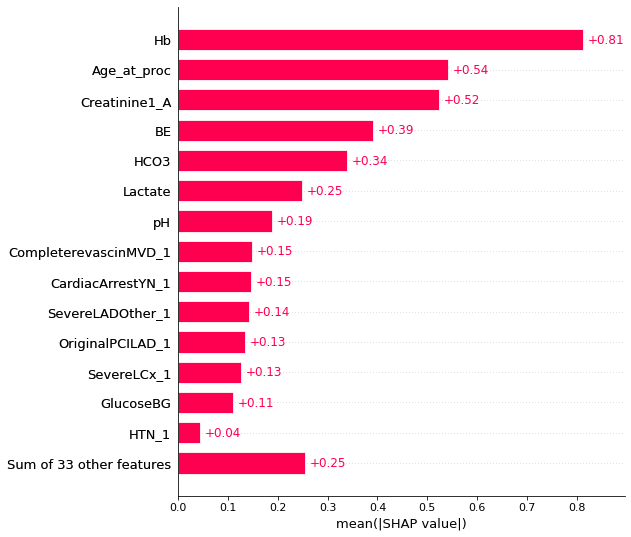

In [54]:
XGB = fitted_models_hy[5]
explainer = shap.Explainer(XGB)
shap_values = explainer(X_test)

#Mean SHAP
shap.plots.bar(shap_values, max_display=15)

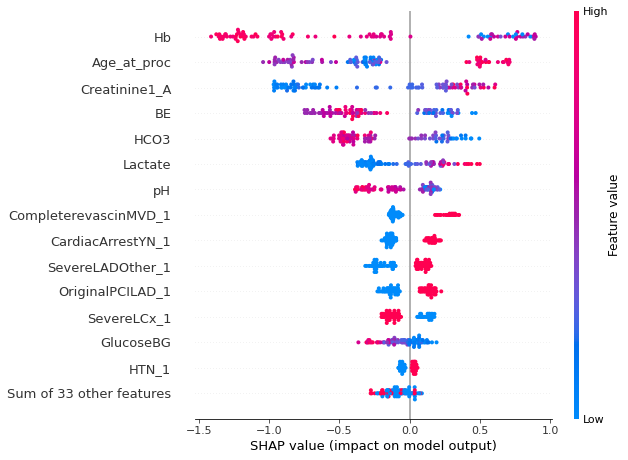

In [59]:
# Beeswarm plot
shap.plots.beeswarm(shap_values, max_display = 15)

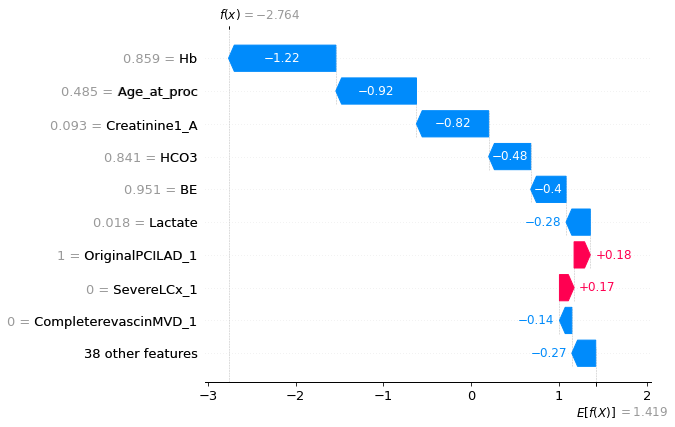

In [61]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values[1])

In [33]:


# Implement k-fold cross vlidation
rkf = KFold(n_splits=5, shuffle=True, random_state=0)  # change random_state
#RepeatedStratifiedKFold(n_splits=k, n_repeats=100, random_state=None)
        
shap_val_list = []
for train_index , test_index in rkf.split(x):
    X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
    
    shap_values = explainer(X_test)
    
    
    
    shap_val_list.append(shap_values)

In [36]:
shap_val_list

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(5,)

In [47]:
shap_values

.values =
array([[-0.9966099 , -0.46576247,  0.4643228 , ..., -0.14318664,
         0.        ,  0.02952405],
       [ 0.8392686 , -0.0917898 , -0.5485788 , ...,  0.03456885,
         0.        ,  0.02501974],
       [ 0.61905575,  0.19678451, -0.2999687 , ..., -0.06994652,
         0.        ,  0.03664237],
       ...,
       [-0.9496939 ,  0.20726223,  0.40606558, ..., -0.12484489,
         0.        , -0.10535501],
       [-1.0591124 , -0.4515407 , -0.8793575 , ...,  0.17331068,
         0.        ,  0.03619355],
       [-0.9430542 , -0.16671601, -0.68758476, ..., -0.23783186,
         0.        ,  0.04875241]], dtype=float32)

.base_values =
array([1.7526441, 1.7526441, 1.7526441, 1.7526441, 1.7526441, 1.7526441,
       1.7526441, 1.7526441, 1.7526441, 1.7526441, 1.7526441, 1.7526441,
       1.7526441, 1.7526441, 1.7526441, 1.7526441, 1.7526441, 1.7526441,
       1.7526441, 1.7526441, 1.7526441, 1.7526441, 1.7526441, 1.7526441,
       1.7526441, 1.7526441, 1.7526441, 1.7526441, 1.7

In [28]:

shap_values = explainer(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [30]:
shap_values.shape

(96, 47)

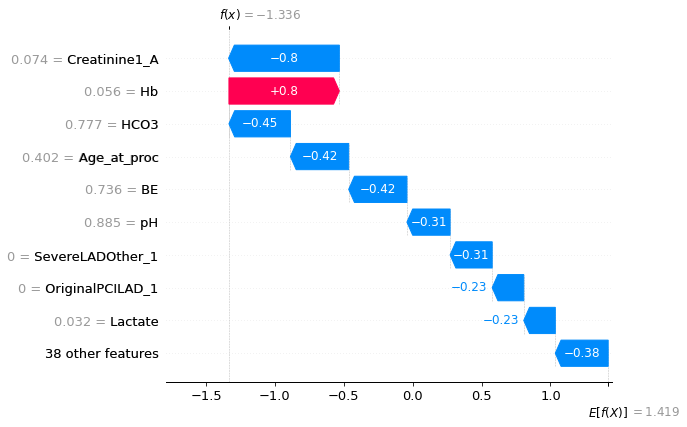

In [58]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

In [ ]:
#Mean SHAP
shap.plots.bar(shap_values, max_display=15)

In [ ]:
# Beeswarm plot
shap.plots.beeswarm(shap_values, max_display = 15)